# Explore Fuse Pose Estimates
Stefan/Yuzhao Heng
Since Tues. Nov. 2nd, 2021

i.e. Get pose candidates from the HSR's laser scan in locating KUKA, and candidates from KUKA's laser scan in locating HSR.


## Setup



In [1]:
from icecream import ic

from scripts.util import *
from scripts.robo_pose_estimator import *


scan_hsr = eg_hsr_scan()



## A straightforward approach: ICP

### Setup

In [2]:
# Empirically have `robot_a` as HSR, `robot_b` as KUKA
ptc_kuka = get_kuka_pointcloud()
fp = PoseEstimator.FusePose(ptc_b=ptc_kuka)



### No guess whatsoever
i.e. Identity transformation


#### Source as laser scans
Not good, too much noise



ic| 'Initial guess': 'Initial guess'
    init_tsf: array([[1., 0., 0.],
                     [0., 1., 0.],
                     [0., 0., 1.]])
ic| tsf_: array([[ 0.99812583, -0.061195  ,  0.24146821],
                 [ 0.061195  ,  0.99812583,  0.38107919],
                 [ 0.        ,  0.        ,  1.        ]])
    tsl: array([0.24146821, 0.38107919])
    degrees(theta): 3.508407094128964


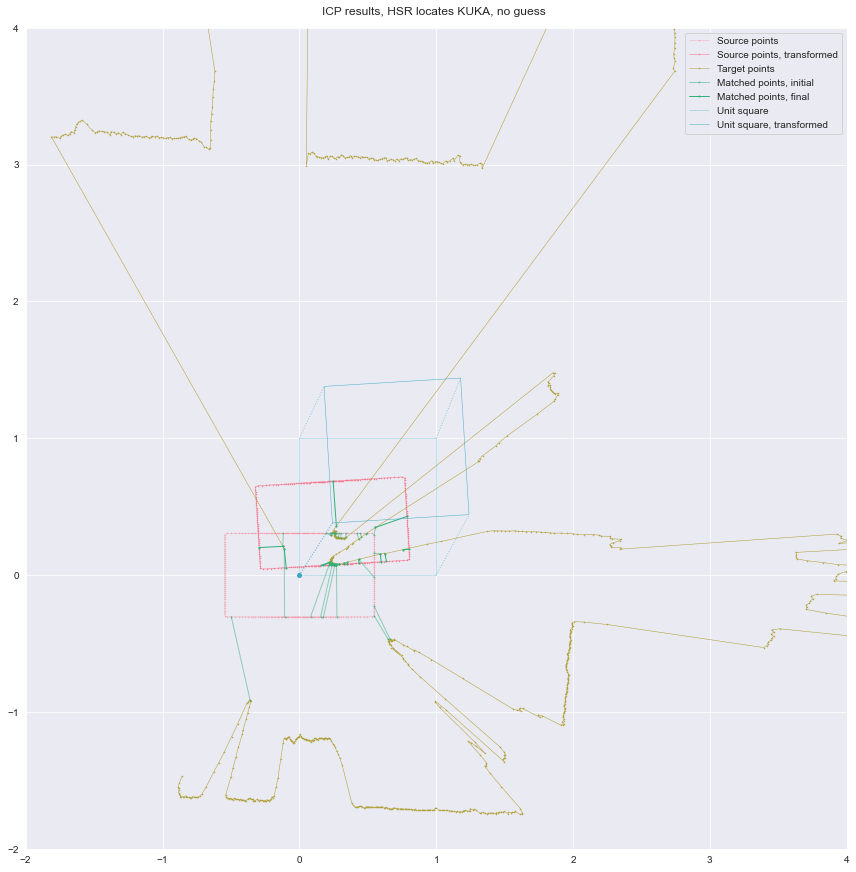

In [3]:
# Icp(ptc_kuka, scan_hsr)(max_iter=100, min_d_err=1e-6)

visualize(
    ptc_kuka, scan_hsr,
    title='HSR locates KUKA, no guess',
    xlim=[-2, 4], ylim=[-2, 4],
    save=True,
    with_arrow=False
)



#### The reversed direction
Since we match each point in source to any points in target, this direction is not good



ic| 'Initial guess': 'Initial guess'
    init_tsf: array([[1., 0., 0.],
                     [0., 1., 0.],
                     [0., 0., 1.]])
ic| tsf_: array([[ 0.78487177, -0.61965822, -1.12707702],
                 [ 0.61965822,  0.78487177, -0.26331015],
                 [ 0.        ,  0.        ,  1.        ]])
    tsl: array([-1.12707702, -0.26331015])
    degrees(theta): 38.29118008554777


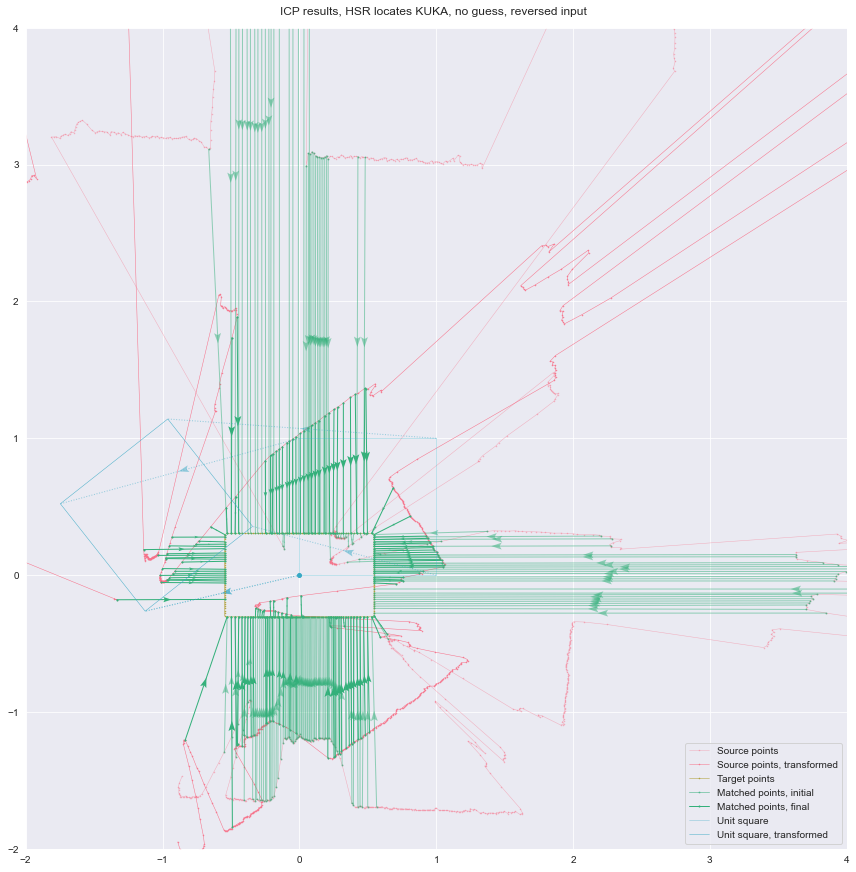

In [4]:
visualize(
    scan_hsr, ptc_kuka,
    title='HSR locates KUKA, no guess, reversed input',
    xlim=[-2, 4], ylim=[-2, 4],
    save=True
)



## An almost perfect guess
Only rotation is wrong, but the raw ICP output is not ideal



ic| 'Initial guess': 'Initial guess'
    init_tsf: array([[ 1. , -0. ,  3. ],
                     [ 0. ,  1. , -0.5],
                     [ 0. ,  0. ,  1. ]])
ic| tsf_: array([[ 0.93987327,  0.34152339,  3.0617858 ],
                 [-0.34152339,  0.93987327, -0.10174199],
                 [ 0.        ,  0.        ,  1.        ]])
    tsl: array([ 3.0617858 , -0.10174199])
    degrees(theta): 19.96971467485378


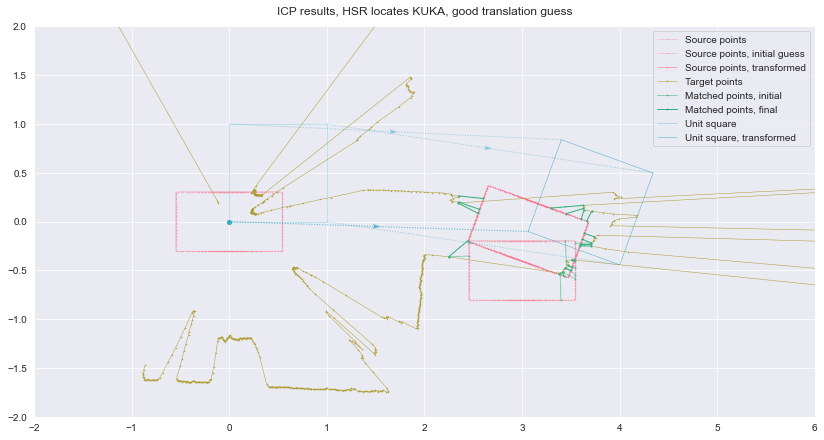

In [5]:
visualize(
    fp.ptc_b, scan_hsr,
    init_tsf=tsl_n_angle2tsf(tsl=[3, -0.5]),
    title='HSR locates KUKA, good translation guess',
    xlim=[-2, 6], ylim=[-2, 2]
)



## Cluster the point clouds first
then run ICP on each, with the relative translation to cluster center


### Clustering
What algorithm work well? Ideally the number of clusters shouldn't be fixed.


#### Setup



In [6]:
c = Cluster.cluster



#### Spectral Clustering



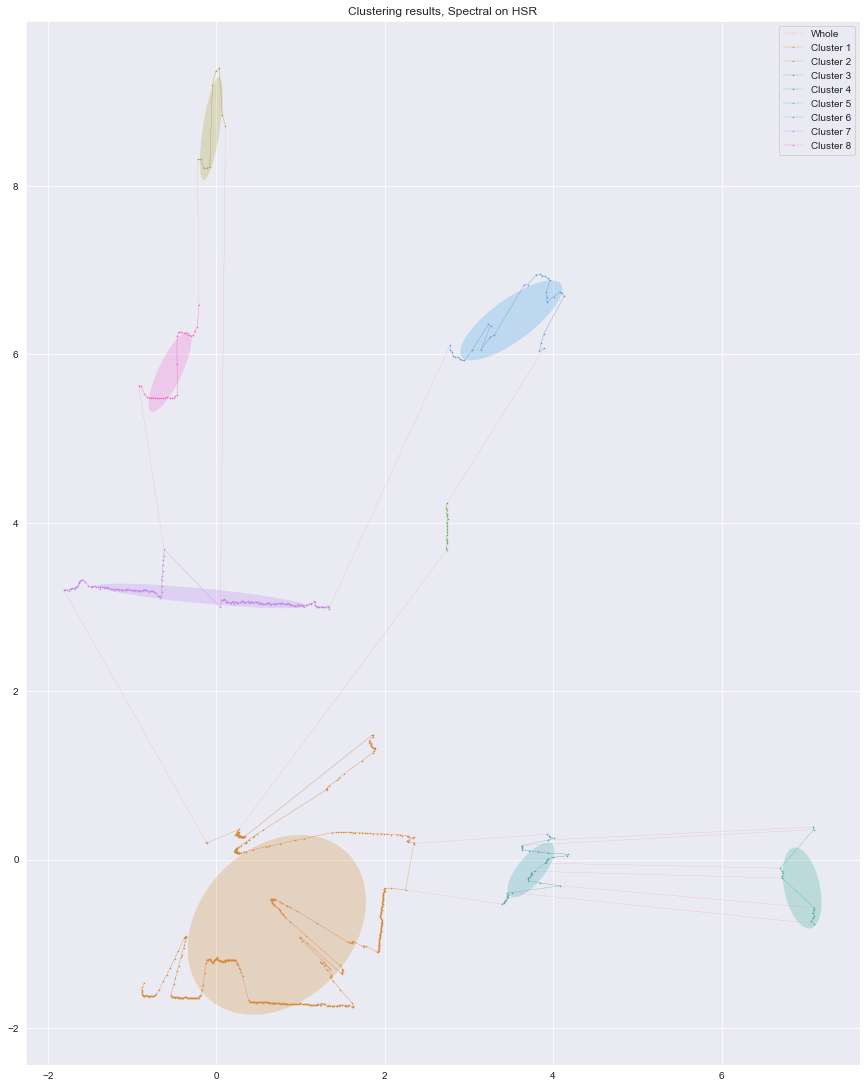

In [7]:
lbs = c(scan_hsr, approach='spectral', n_clusters=8)
plot_cluster(scan_hsr, lbs, title='Spectral on HSR')



#### Hierarchical Clustering



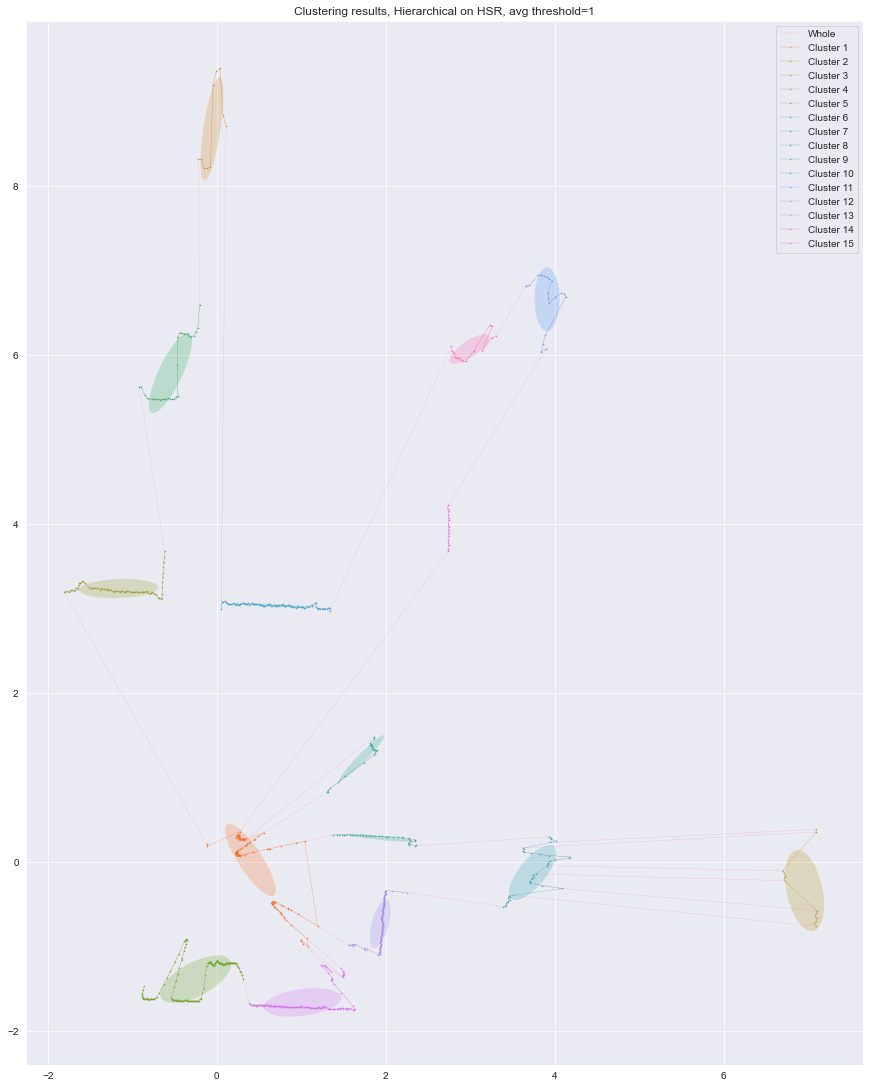

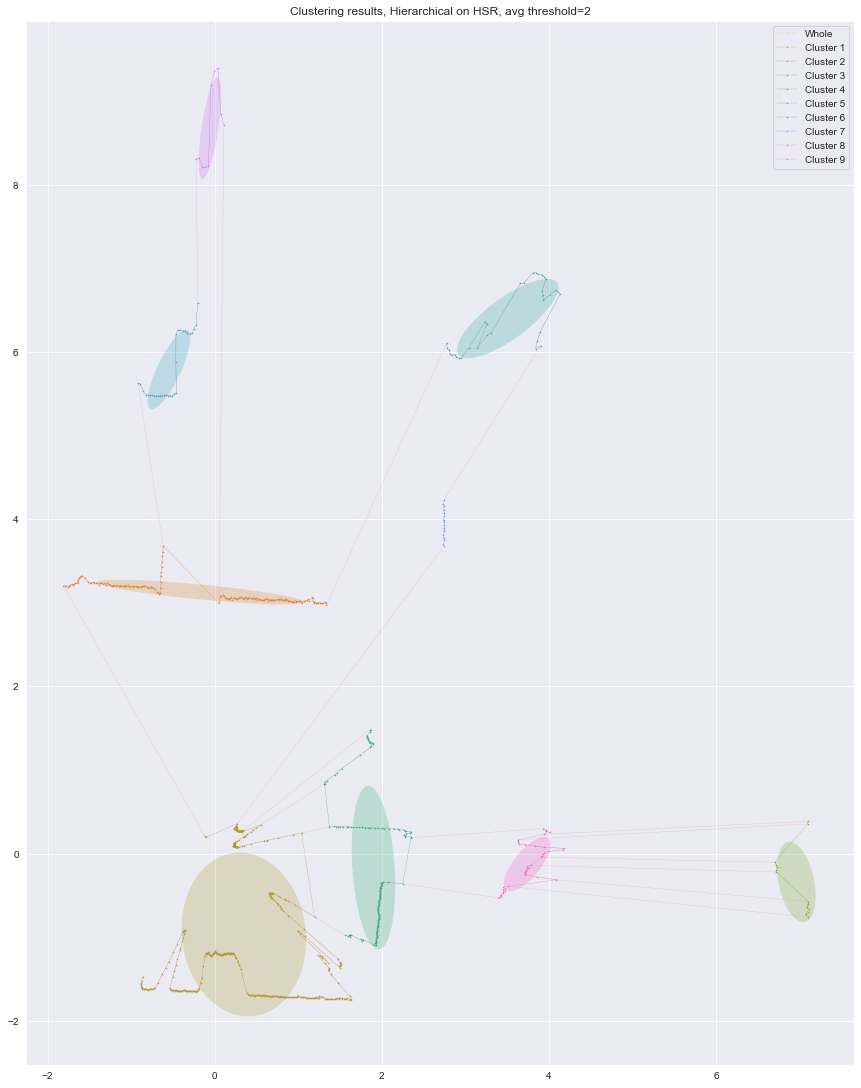

In [8]:
def _(d):
    lbs = c(scan_hsr, approach='hierarchical', distance_threshold=d)
    plot_cluster(scan_hsr, lbs, title=f'Hierarchical on HSR, avg threshold={d}')

_(1)
_(2)



#### Gaussian Mixture Model assignment



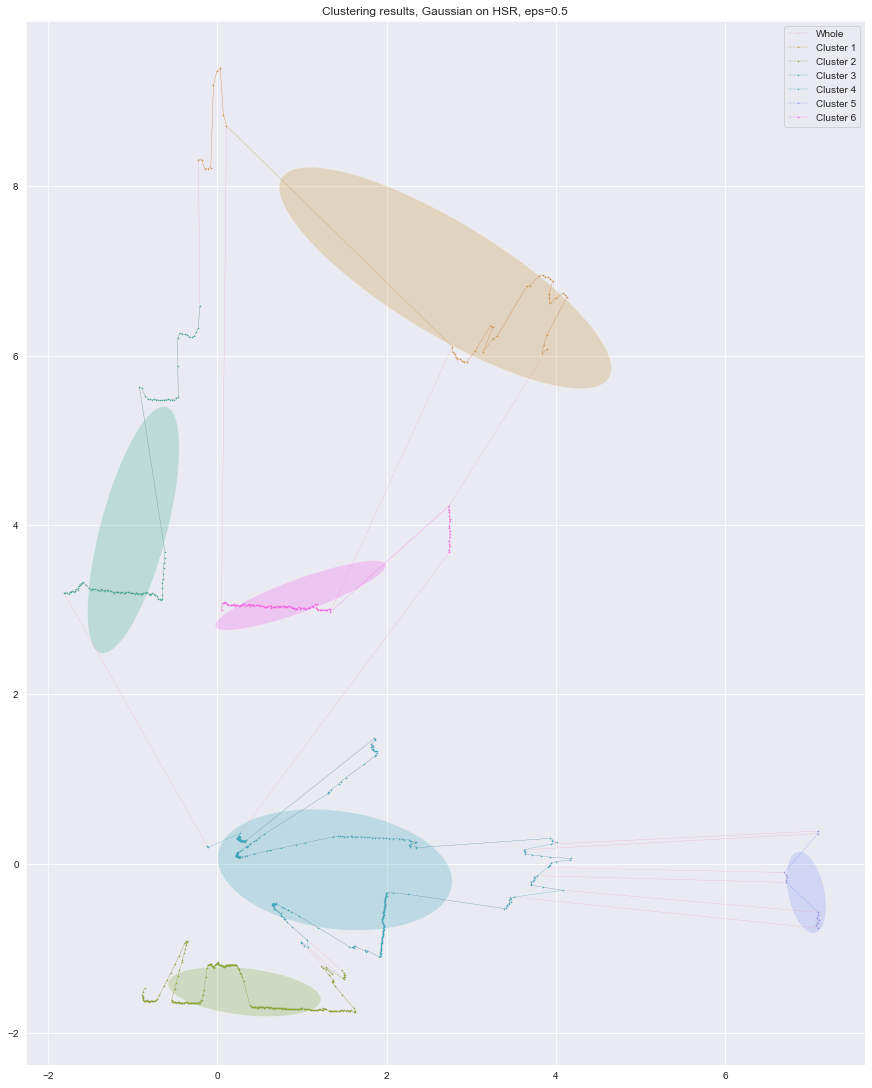

In [9]:
lbs = c(scan_hsr, approach='gaussian', n_components=6)
plot_cluster(scan_hsr, lbs, title='Gaussian on HSR, eps=0.5')



#### DBSCAN



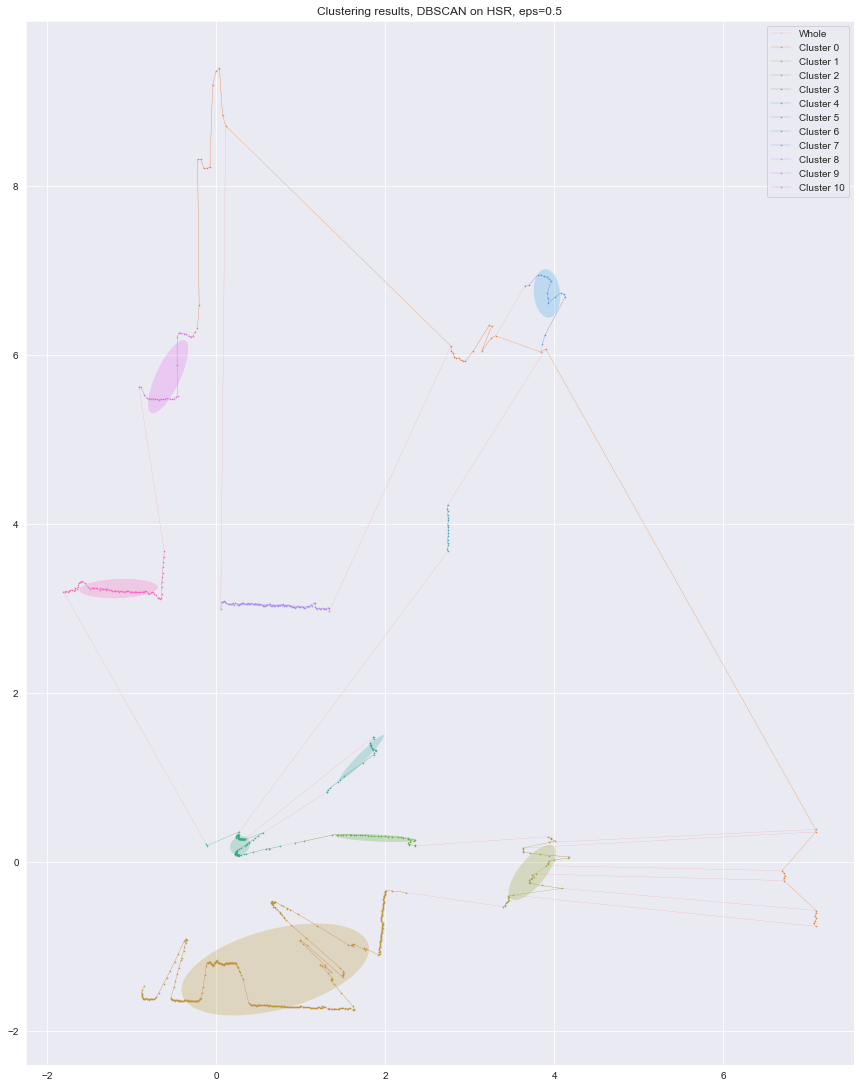

In [10]:
lbs = c(scan_hsr, approach='dbscan', eps=0.5, min_samples=16)
plot_cluster(scan_hsr, lbs, title='DBSCAN on HSR, eps=0.5')


### ICP with cluster translation initialisation


ic| 'Initial guess': 'Initial guess'
    init_tsf: array([[ 1.        , -0.        ,  1.93388482],
                     [ 0.        ,  1.        , -0.72910732],
                     [ 0.        ,  0.        ,  1.        ]])
ic| tsf_: array([[ 8.71533621e-01, -4.90335749e-01, -1.76717664e+06],
                 [ 4.90335749e-01,  8.71533621e-01,  5.71499516e+04],
                 [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
    tsl: array([-1767176.63826941,    57149.95164331])
    degrees(theta): 29.362651800084343


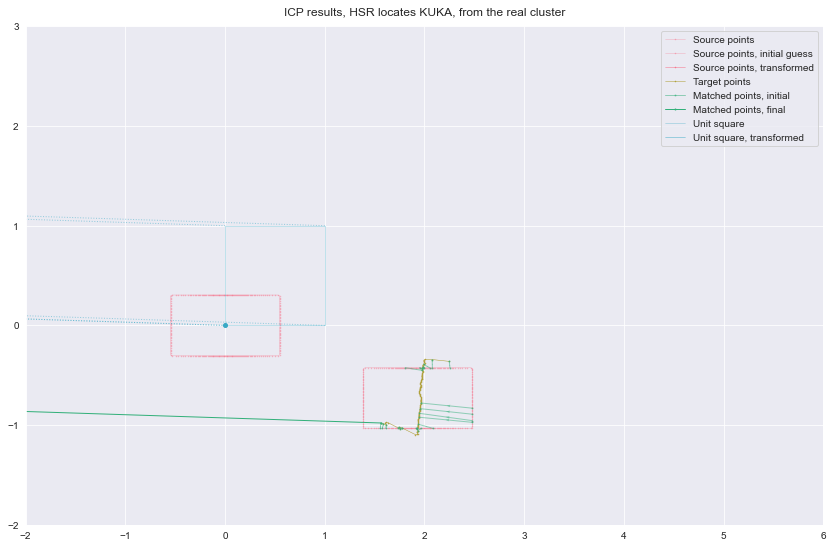

In [15]:
lbs = c(scan_hsr, approach='hierarchical', distance_threshold=1)   # A good clustering result by empirical inspection
d_clusters = {lb: scan_hsr[np.where(lbs == lb)] for lb in np.unique(lbs)}

cls = d_clusters[11]  # The cluster indicating real location of KUKA

visualize(
    ptc_kuka, cls,
    title='HSR locates KUKA, from the real cluster',
    init_tsf=tsl_n_angle2tsf(tsl=cls.mean(axis=0)),
    xlim=[-2, 6], ylim=[-2, 3],
    save=True
)


#### What if start with good translation guess?


ic| 'Initial guess': 'Initial guess'
    init_tsf: array([[ 1. , -0. ,  2.5],
                     [ 0. ,  1. , -0.5],
                     [ 0. ,  0. ,  1. ]])
ic| tsf_: array([[-8.15774697e-01, -5.78369816e-01,  4.20183058e+28],
                 [-5.78369816e-01,  8.15774697e-01,  1.33838850e+28],
                 [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
    tsl: array([4.20183058e+28, 1.33838850e+28])
    degrees(theta): 144.6640343360472


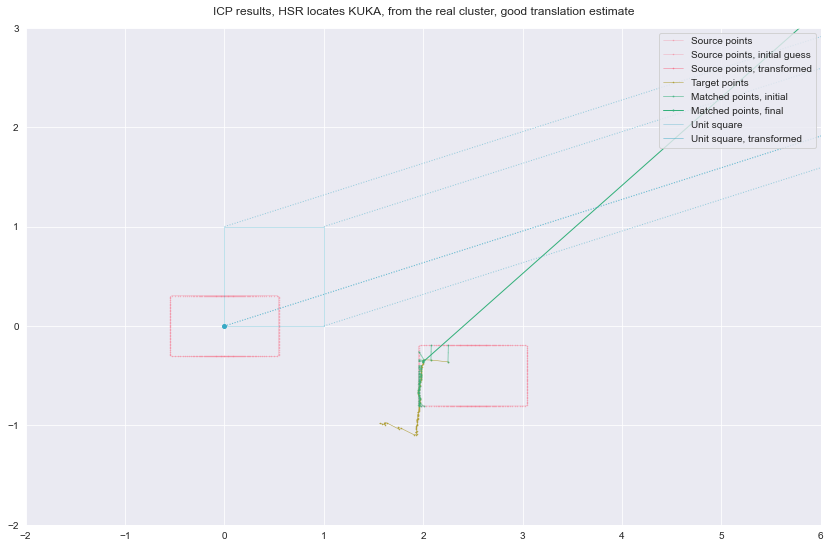

ic| 'Initial guess': 'Initial guess'
    init_tsf: array([[ 1.  , -0.  ,  2.5 ],
                     [ 0.  ,  1.  , -0.75],
                     [ 0.  ,  0.  ,  1.  ]])
ic| tsf_: array([[-2.21808841e-01, -9.75090169e-01,  5.58415371e+21],
                 [ 9.75090169e-01, -2.21808841e-01, -6.68346721e+21],
                 [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
    tsl: array([ 5.58415371e+21, -6.68346721e+21])
    degrees(theta): 102.81529719162451


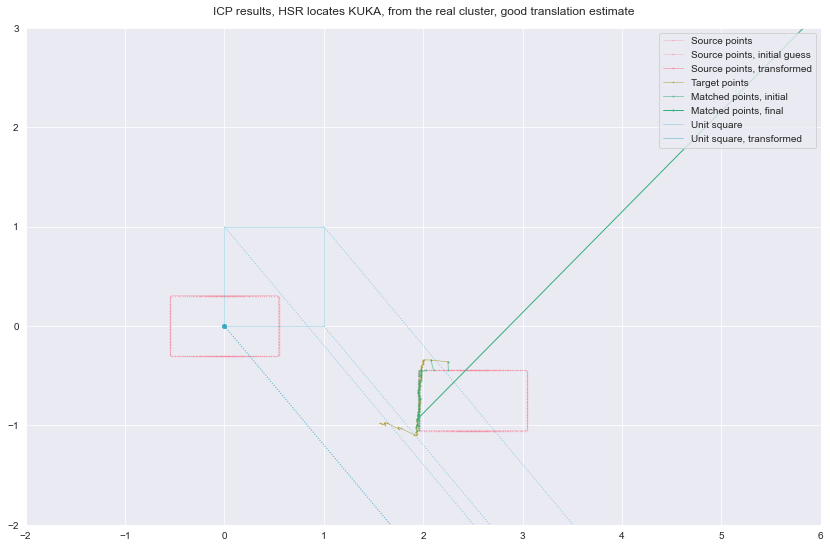

In [25]:
visualize(
    ptc_kuka, cls,
    title='HSR locates KUKA, from the real cluster, good translation estimate',
    init_tsf=tsl_n_angle2tsf(tsl=[2.5, -0.5]),
    xlim=[-2, 6], ylim=[-2, 3], mode='static',
    save=True
)
visualize(
    ptc_kuka, cls,
    title='HSR locates KUKA, from the real cluster, good translation estimate',
    init_tsf=tsl_n_angle2tsf(tsl=[2.5, -0.75]),
    xlim=[-2, 6], ylim=[-2, 3], mode='static',
    save=True
)


#### On top of translation guess, reverse?



ic| 'Initial guess': 'Initial guess'
    init_tsf: array([[ 1. , -0. , -2.5],
                     [ 0. ,  1. ,  0.5],
                     [ 0. ,  0. ,  1. ]])
ic| tsf_: array([[ 0.99816863, -0.06049278, -2.55706972],
                 [ 0.06049278,  0.99816863,  0.49967637],
                 [ 0.        ,  0.        ,  1.        ]])
    tsl: array([-2.55706972,  0.49967637])
    degrees(theta): 3.4680984085473248


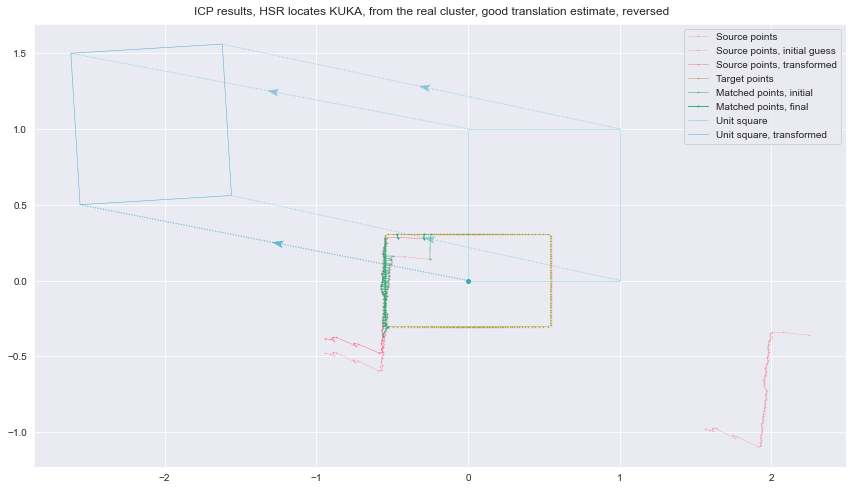

In [24]:
visualize(
    cls, ptc_kuka,
    title='HSR locates KUKA, from the real cluster, good translation estimate, reversed',
    init_tsf=tsl_n_angle2tsf(tsl=[-2.5, 0.5]),
    # xlim=[-2, 6], ylim=[-2, 3], mode='static',
    # save=True
)

